### Pre-process necessary features:

In [109]:
#import necessary libraries 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2
from sklearn.ensemble import RandomForestClassifier


In [100]:
# load the dataset

df = pd.read_csv('toy_dataset.csv')
df = df.drop('Number', axis=1) # dropping the Number col because it is index col
df.head()

,City,Gender,Age,Income,Illness
0,Dallas,Male,41,40367.0,No
1,Dallas,Male,54,45084.0,No
2,Dallas,Male,42,52483.0,No
3,Dallas,Male,40,40941.0,No
4,Dallas,Male,46,50289.0,No


In [101]:
# Check if there are any missing values in the entire DataFrame
if df.isnull().values.any():
    print("There are missing values in the DataFrame.")

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   City     150000 non-null  object 
 1   Gender   150000 non-null  object 
 2   Age      150000 non-null  int64  
 3   Income   150000 non-null  float64
 4   Illness  150000 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 5.7+ MB


### Design 2 new features:

We are adding for the additional features, the frequency of the city and the age group. These two can potentially provide additional information that may help in predicting illness. Here's how these features can be helpful:

Frequency of City: By including the frequency of each city as a feature, we are capturing the occurrence or representation of each city in the dataset. If there is any correlation between the city and the presence of illness, this feature can help the model identify patterns or associations. For example, if certain cities have a higher frequency of illness cases, it may indicate a higher prevalence of illness in those areas.

Age Group: By grouping ages into categories or age groups, you are simplifying the age feature, which can help in identifying any patterns related to different age ranges and their association with illness. Certain illnesses or health conditions might be more prevalent in specific age groups. By creating this feature, the model can potentially capture any age-related trends or relationships with illness.

In [103]:
# Create frequency of city feature
city_frequency = df['City'].value_counts()
df['CityFrequency'] = df['City'].map(city_frequency)

# Create age group feature
age_bins = [0, 30, 60, 100]  # Define age group bins
age_labels = ['Young', 'Middle-aged', 'Senior']  # Define age group labels
df['AgeGroup'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels)

df.head()

,City,Gender,Age,Income,Illness,CityFrequency,AgeGroup
0,Dallas,Male,41,40367.0,No,19707,Middle-aged
1,Dallas,Male,54,45084.0,No,19707,Middle-aged
2,Dallas,Male,42,52483.0,No,19707,Middle-aged
3,Dallas,Male,40,40941.0,No,19707,Middle-aged
4,Dallas,Male,46,50289.0,No,19707,Middle-aged


### Perform one-hot encoding for categorical variables like Gender and AgeGroup

In [104]:

# Perform one-hot encoding for Gender and AgeGroup
categorical_features = ['Gender', 'City', 'AgeGroup', 'Illness']
categorical_transformer = ColumnTransformer(
    transformers=[('encoder', OneHotEncoder(), categorical_features)],
    remainder='passthrough'
)
df_encoded = categorical_transformer.fit_transform(df)

# Convert the encoded data back to a DataFrame
df_encoded = pd.DataFrame(df_encoded, columns=categorical_transformer.get_feature_names_out())

df_encoded.head()


,encoder__Gender_Female,encoder__Gender_Male,encoder__City_Austin,encoder__City_Boston,encoder__City_Dallas,encoder__City_Los Angeles,encoder__City_Mountain View,encoder__City_New York City,encoder__City_San Diego,encoder__City_Washington D.C.,encoder__AgeGroup_Middle-aged,encoder__AgeGroup_Senior,encoder__AgeGroup_Young,encoder__Illness_No,encoder__Illness_Yes,remainder__Age,remainder__Income,remainder__CityFrequency
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,41.0,40367.0,19707.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,54.0,45084.0,19707.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,42.0,52483.0,19707.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,40.0,40941.0,19707.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,46.0,50289.0,19707.0


### Predict if person is ill:

In [105]:
# Select features and target variable
features = ['Gender', 'CityFrequency', 'AgeGroup']  # Add more features if needed
target = 'Illness'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

# Define preprocessing steps
categorical_features = ['Gender', 'AgeGroup']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Fit the pipeline (preprocessing + model training) on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9207666666666666


### Find top 3 predictive features according to 3 different methods of measuring predictiveness

The first method we use here is **Mutual Information** because it captures both linear and non-linear relationships, ranks features based on their predictiveness, and does not assume specific data distributions. It considers feature interactions and provides flexibility in selecting the desired number of informative features.

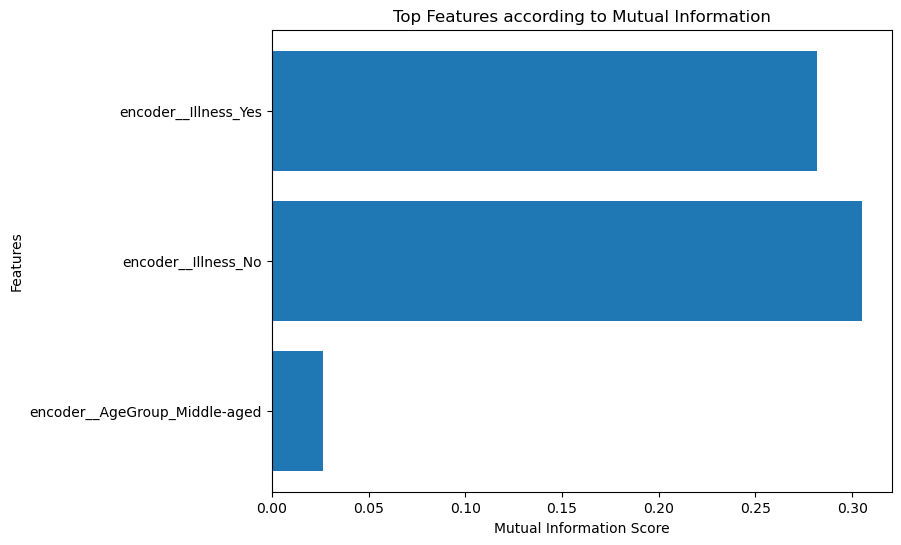

In [98]:
# Method 1: Mutual Information
selector_mi = SelectKBest(score_func=mutual_info_classif, k=3)
selector_mi.fit(df_encoded, df[target])
top_features_mi = df_encoded.columns[selector_mi.get_support()].tolist()

# # Print the top 3 features according to Mutual Information
# print("Top 3 features according to Mutual Information:", top_features_mi)

# Create a bar plot for the top features
plt.figure(figsize=(8, 6))
plt.barh(range(len(top_features_mi)), selector_mi.scores_[selector_mi.get_support()])
plt.yticks(range(len(top_features_mi)), top_features_mi)
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.title('Top Features according to Mutual Information')
plt.show()

**Results method 1 :**
According to the mutual information scores, the middle-aged age group, the absence of illness, and the presence of illness are the top 3 features that have the highest predictive power for determining the target variable.

'AgeGroup_Middle-aged': This feature indicates the middle-aged age group. According to mutual information, this feature has a strong predictive relationship with the target variable.

'Illness_No': This feature represents the absence of illness. Mutual information suggests that the absence of illness has a high predictive value for determining the target variable.

'Illness_Yes': This feature represents the presence of illness. Mutual information indicates that the presence of illness also has a strong predictive relationship with the target variable.




**Method 2 correlation matrix**

In Method 2, which uses the correlation matrix, we calculate the correlation coefficients between each feature and the target variable. The absolute values of these correlation coefficients are then sorted to identify the features that have the strongest correlation with the target.

By selecting features with high correlation coefficients, we aim to identify variables that exhibit a strong linear relationship with the target variable. These features may have a higher predictive power and can be useful for modeling and prediction tasks.

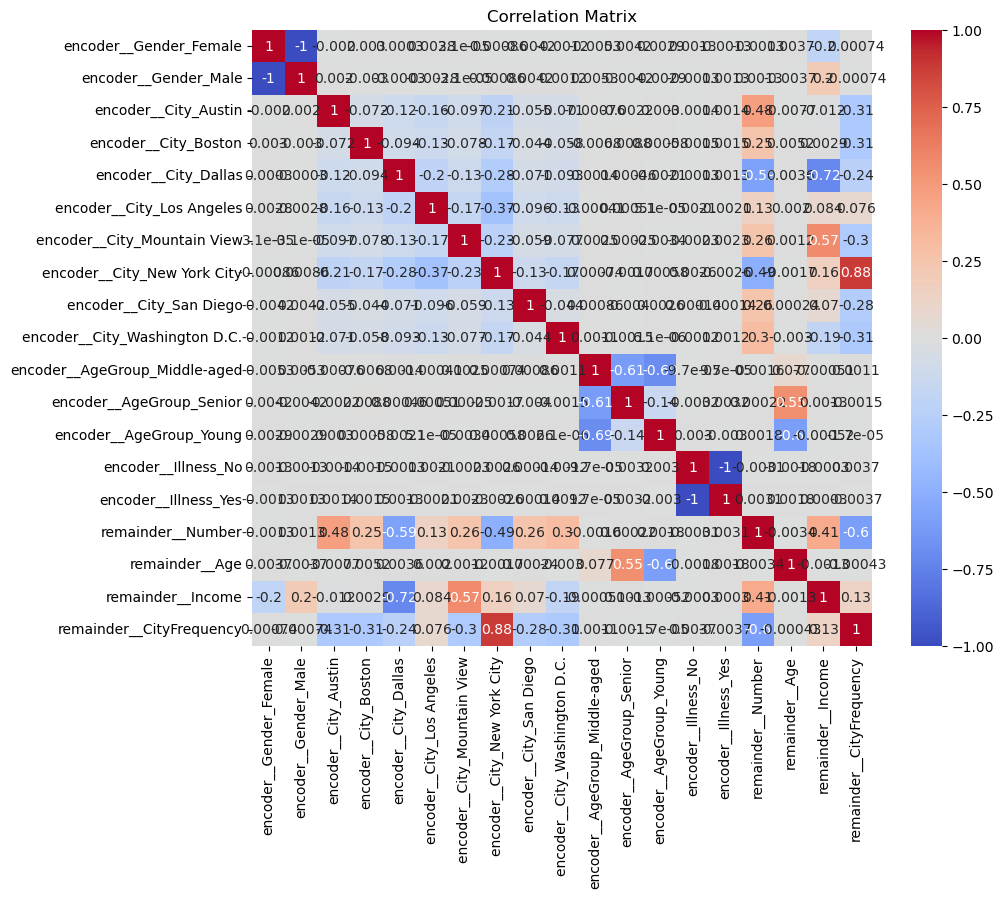

In [79]:
# Calculate the correlation matrix
corr_matrix = df_encoded.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

**Method 3: Feature Importance (Random Forest)**

We use Feature Importance (Random Forest) is a method that helps us understand which features are most important for making accurate predictions. It uses a combination of decision trees to analyze the data and figure out which features have the biggest impact. This method is helpful when dealing with complicated relationships between features and the outcome we want to predict. By knowing which features are most important, we can focus on them and gain insights into the patterns in the data. It's like finding the key puzzle pieces that help us understand the big picture.


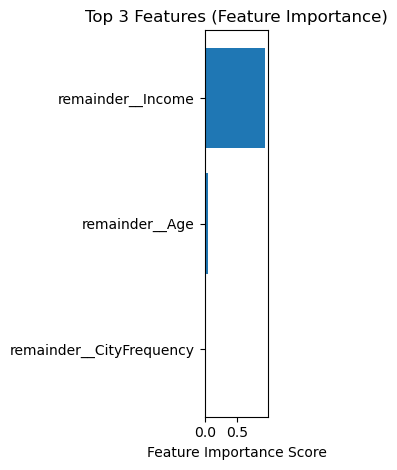

In [106]:
# Method 3: Feature Importance (Random Forest)
# Select features and target variable
features = df_encoded.drop(['encoder__Illness_No', 'encoder__Illness_Yes'], axis=1)
target = df_encoded['encoder__Illness_Yes']

rf = RandomForestClassifier()
rf.fit(features, target)
importance_scores = rf.feature_importances_
importance_features = pd.Series(importance_scores, index=features.columns).nlargest(3).index.tolist()

plt.subplot(1, 3, 3)
plt.barh(range(3), importance_scores[importance_scores.argsort()[-3:]])
plt.yticks(range(3), features.columns[importance_scores.argsort()[-3:]])
plt.xlabel('Feature Importance Score')
plt.title('Top 3 Features (Feature Importance)')

plt.tight_layout()
plt.show()

The "remainder_Income" feature has the highest number of non-zero values, indicating that it contains the most diverse and informative data points. It suggests that "Income" has a significant impact on the target variable.

The "remainder_Age" feature has the second-lowest number of non-zero values, implying that it has relatively fewer distinct values compared to other features. This suggests that "Age" may have less variation and potentially less influence on the target variable.

The "cityFrequency" feature has the lowest number of non-zero values among all the remaining features. This indicates that there may be limited diversity in the frequency of cities within the dataset, suggesting that it may have a less significant impact on predicting the target variable.

These results provide insights into the distribution and diversity of values in the remaining features, highlighting the potential importance and impact of each feature on predicting the target variable.

### Report score/accuracy in at least 2 different formats

1. The accuracy_score() function calculates the accuracy by comparing the predicted labels (y_pred) with the actual labels (y_test). The accuracy is then printed. (N.B: We already used this to check the accuracy rate right after training our model.)

2. The classification_report() function generates a detailed report including precision, recall, F1-score, and support for each class. The classification report is printed as well.

In [107]:
# Calculate accuracy using accuracy_score()
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9207666666666666


In [113]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')
# Generate classification report using classification_report()
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

          No       0.92      1.00      0.96     27623
         Yes       0.00      0.00      0.00      2377

    accuracy                           0.92     30000
   macro avg       0.46      0.50      0.48     30000
weighted avg       0.85      0.92      0.88     30000

